In [2]:
import pandas as pd
import numpy as np
import ast
#import seaborn
from collections import Counter
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
from bs4 import BeautifulSoup

In [3]:
def load(filename):
    file = open(filename,'rb')
    obj = pickle.load(file)
    file.close()
    return obj
    
def dump(obj,filename):
    filehandler = open(filename,"wb")
    pickle.dump(obj,filehandler)
    filehandler.close()

In [5]:
pitt_review = load("../../Pickled_files/pitt_review.pkl")
pitt_review["word_freq"] = map(lambda x: Counter(x),pitt_review["clean_text"])

In [126]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import matplotlib as mpl

def myFormatter(x, pos):
    return pd.to_datetime(x,format="%Y-%m").year

In [7]:
pitt_review["date"] = map(lambda x: pd.datetime.strptime(x, '%Y-%m-%d'),pitt_review["date"])
pitt_review["month"] = map(lambda x: x.month , pitt_review["date"])
pitt_review["year"] = map(lambda x: x.year , pitt_review["date"])
pitt_review["nreviews"] = 1 

In [200]:
def plot_word_trends(word_list,name="",flag = 0, wind=5, city="_"):
    
    
    temp = pitt_review.copy()
    
    if len(name) > 0:
        temp = temp[temp["name"]==name]

        
    for words in word_list:
        temp["x"] = 0
        for word in words:
            temp["x"] = temp["x"] | map(lambda x: 1 if x[word] > 0 else 0, temp["word_freq"])
        word_name = "_".join(words)
        temp[word_name] =  temp["x"]

    words = map(lambda x: "_".join(x),word_list)
    
    feat = ["month","year","nreviews"] + words
    
    if len(name) > 0 and flag:
        feat = feat + ["stars_x"]
    
    avgStatspitt = temp.groupby(by=["year","month"]).sum()
        
    for word in words:
        avgStatspitt[word + city] = avgStatspitt[word]/avgStatspitt["nreviews"]
        avgStatspitt[word + city] = avgStatspitt[word + city].rolling(window = wind).mean()
        
    if len(name) > 0 and flag:
        avgStatspitt["stars_x"] = (avgStatspitt["stars_x"] - 1)/(avgStatspitt["nreviews"]*4)
        avgStatspitt["stars_x"] = avgStatspitt["stars_x"].rolling(window = wind).mean()
    
    feat_prop = map(lambda x: x + city ,words)
    avgStatspitt.reset_index(inplace=True)
    
    avgStatspitt = avgStatspitt[avgStatspitt["year"] > 2008]
    
    ym = zip(avgStatspitt["year"],avgStatspitt["month"])
    ym  = map(lambda x: str(x[0]) + "-" + str(x[1]),ym)
    avgStatspitt["date"] = map(lambda x: pd.datetime.strptime(x, '%Y-%m'),ym)
        
    if len(name) > 0 and flag:
        feat_prop = feat_prop + ["stars_x"]
     
    pm = pd.melt(avgStatspitt, id_vars=['date'], value_vars=feat_prop)
    pm["Dummy"] = 0

    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.tsplot(data=pm, time="date", condition="variable",unit="Dummy", value="value",ax = ax)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(myFormatter))
    fig.autofmt_xdate()
    plt.show()
    return pm

def transform_data_d3(word_trend):
    d3_data = word_trend[["variable","date","value"]]
    d3_data = d3_data.rename(index=str, columns={"variable": "symbol", "date": "date","value":"price"})
    d3_data = d3_data.dropna()
    d3_data.to_csv("d3_data.csv",index=False)

## By Restaurant 
##### Here in the example say you want to group boolean word presence of two words say service and time because you might think they might related then put them in a single list
##### Note: When restaurant is also specified it plots rating as well

### You can also bin these multiple list by topics we have defined to see change in topics over time

##### Note: Flag = 1 to get rating plot and flag = 0 to not plot it 

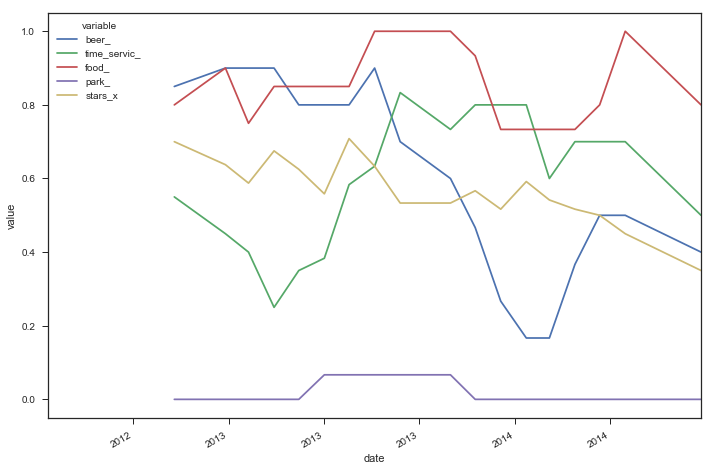

In [202]:
word_trend = plot_word_trends(word_list = [["beer"],["time","servic"],["food"],["park"]],name="Brewstone",flag = 1,wind=5)
transform_data_d3(word_trend)

### This is not by restaurant in general

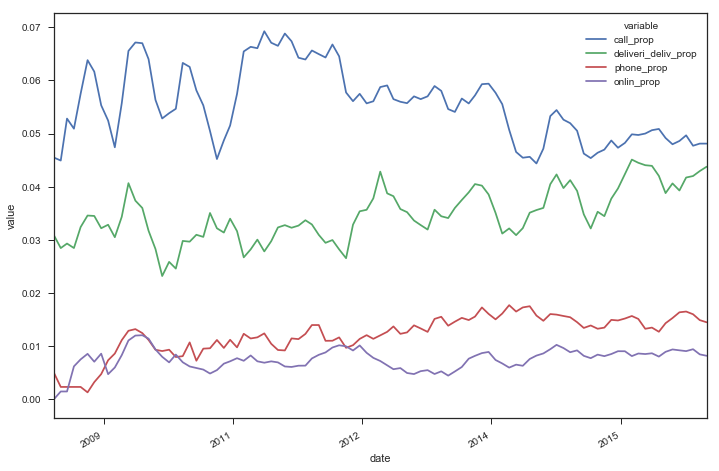

In [196]:
word_trend = plot_word_trends(word_list = [["call"],["deliveri","deliv"],["phone"],["onlin"]],wind=5)
transform_data_d3(word_trend)

### Say you want to compare different  cusine in Pittsburgh

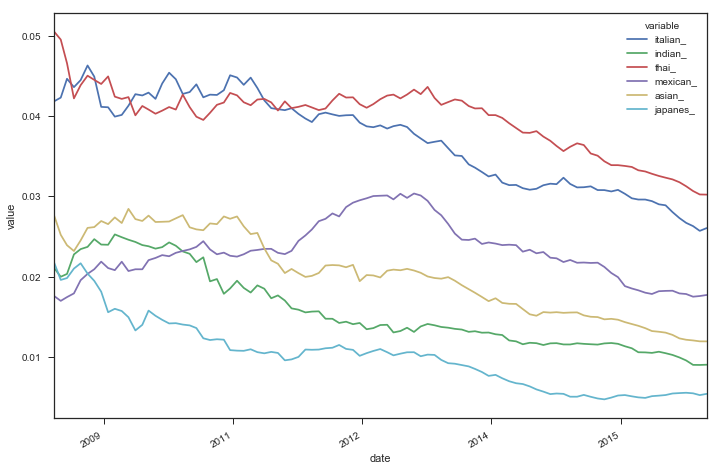

In [203]:
word_trend = plot_word_trends(word_list = [["italian"],["indian"],["thai"],["mexican"],["asian"],["japanes"]],wind=20)
transform_data_d3(word_trend)

## City wise Pass city name

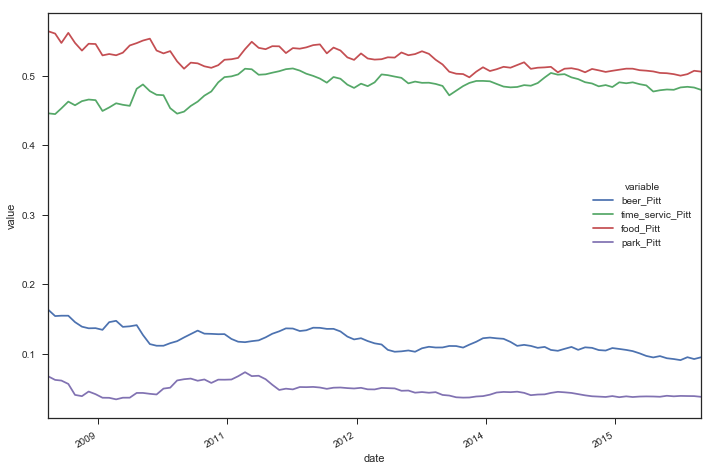

In [206]:
word_trend = plot_word_trends(word_list = [["beer"],["time","servic"],["food"],["park"]],wind=5,city="_Pitt")
transform_data_d3(word_trend)

## Change in no of reviews over time

In [151]:
temp = pitt_review[["year","month","nreviews"]].groupby(["year","month"]).sum()
temp.reset_index(inplace=True)
ym = zip(temp["year"],temp["month"])
ym  = map(lambda x: str(x[0]) + "-" + str(x[1]),ym)
temp["date"] = map(lambda x: pd.datetime.strptime(x, '%Y-%m'),ym)

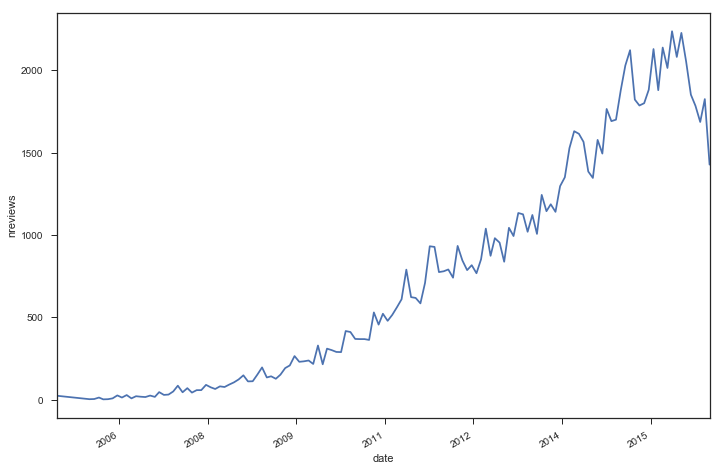

In [161]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
temp["Dummy"] = 0
sns.tsplot(data = temp, time="date",unit="Dummy", value = "nreviews")
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(myFormatter))
fig.autofmt_xdate()
plt.show()

In [194]:
pitt_review["stars_y"]

1032       2.5
1033       2.5
1034       2.5
1035       2.5
1036       2.5
1037       2.5
1038       2.5
1039       2.5
1040       2.5
1041       2.5
1042       2.5
1043       2.5
1044       2.5
1045       2.5
1046       2.5
1047       2.5
1048       2.5
1049       2.5
1050       2.5
1051       2.5
1052       2.5
1053       2.5
1054       2.5
1055       2.5
1056       2.5
1057       2.5
1058       2.5
1059       2.5
1060       2.5
1061       2.5
          ... 
2577083    3.5
2577084    3.5
2577085    3.5
2577086    3.5
2577087    3.5
2577088    3.5
2577089    3.5
2577090    3.5
2577091    3.5
2577092    3.5
2577093    3.5
2577094    3.5
2577095    3.5
2577096    3.5
2577097    3.5
2577098    3.5
2577099    3.5
2577100    3.5
2577101    3.5
2577102    3.5
2577103    3.5
2577104    3.5
2577105    3.5
2577106    3.5
2577107    3.5
2577108    3.5
2577109    3.5
2577110    3.5
2577111    3.5
2577112    3.5
Name: stars_y, dtype: float64

In [195]:
pitt_review["stars_x"]

1032       3
1033       3
1034       1
1035       1
1036       4
1037       3
1038       3
1039       3
1040       5
1041       1
1042       2
1043       2
1044       4
1045       4
1046       2
1047       4
1048       1
1049       3
1050       2
1051       4
1052       1
1053       4
1054       2
1055       1
1056       2
1057       4
1058       1
1059       3
1060       1
1061       4
          ..
2577083    4
2577084    3
2577085    4
2577086    4
2577087    5
2577088    5
2577089    4
2577090    4
2577091    1
2577092    2
2577093    4
2577094    2
2577095    5
2577096    5
2577097    4
2577098    2
2577099    4
2577100    4
2577101    3
2577102    2
2577103    5
2577104    4
2577105    3
2577106    5
2577107    2
2577108    4
2577109    4
2577110    4
2577111    4
2577112    3
Name: stars_x, dtype: int64